In [ ]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
df = pd.read_excel("RUT RV.xlsx",index_col='Date',parse_dates=True)

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [ ]:
df.head()

,ds,wasserstein_dists_2D,y,VIX,unique_id
0,2000-02-01,0.067382,0.013067,23.450001,airplane1
1,2000-02-02,0.049767,0.007825,23.120001,airplane1
2,2000-02-03,0.039045,0.008674,22.010000,airplane1
3,2000-02-04,0.037064,0.006248,21.540001,airplane1
4,2000-02-07,0.042502,0.004970,22.790001,airplane1


In [ ]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]


# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 35952799


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 6559464


Epoch: 250 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.0038099426681538757 | QLIKE: 0.1252496668553582


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34886551


Epoch: 250 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0033758090123660062 | QLIKE: 0.09740429463642072


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 61623596


Epoch: 100 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.003921711296382141 | QLIKE: 0.14043555053096024


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 22353973


Epoch: 50 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0038235275632013906 | QLIKE: 0.13219050284019151


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.003919985453212643 | QLIKE: nan


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 506809


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 45196426


Epoch: 25 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0039050466113005867 | QLIKE: 0.1221391071302568


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 79678772


Epoch: 250 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.003626451187277413 | QLIKE: 0.11766646747723408


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 14106291


Epoch: 550 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.003452295883861936 | QLIKE: 0.09974147470807002


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27559106


Epoch: 550 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0038467319041307563 | QLIKE: 0.13260551045185434


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.0035830675882422363 | QLIKE: 0.11677838146101857


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 10927951


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 33082487


Epoch: 450 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0031837733173586723 | QLIKE: 0.08610690119943039


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 86454079


Epoch: 100 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0038887588189792455 | QLIKE: 0.12392259904945184


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69510124


Epoch: 450 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.003245666851096557 | QLIKE: 0.09119647437850285


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 85541414


Epoch: 50 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.003626539736483375 | QLIKE: 0.1068376296883363


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [1, 1]
RMSE: 0.00367366980756202 | QLIKE: 0.11318565553196994


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 98445365


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 119829465


Epoch: 750 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.0036012588933652147 | QLIKE: 0.11264057274067713


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 7024442


Epoch: 750 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.0031964543047719317 | QLIKE: 0.09176399327661926


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 4212356


Epoch: 550 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.003454489984891462 | QLIKE: 0.11319570791705141


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91413943


Epoch: 450 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0031745314627462753 | QLIKE: 0.08676694319916475


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 550 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.003242773638882151 | QLIKE: 0.08513652686171785


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 63134315


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 120773847


Epoch: 350 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.0036755831150732748 | QLIKE: 0.12079639405797324


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 37191782


Epoch: 550 | Inputs: 252 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.003422916251526803 | QLIKE: 0.10853723114895442


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 74061820


Epoch: 50 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.003239393489431774 | QLIKE: 0.08314972008816


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44608867


Epoch: 250 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0035289827519233386 | QLIKE: 0.11410593037789289


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 350 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.0032373770388193536 | QLIKE: 0.08954102199298575


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 25827515


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 84560194


Epoch: 450 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.0033198058374150703 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 74315449


Epoch: 50 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0038904541811849496 | QLIKE: 0.13407320701546868


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109362198


Epoch: 350 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0033904422018810596 | QLIKE: 0.09645053234587476


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124809331


Epoch: 25 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.003584650017843995 | QLIKE: 0.10265817789419944


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 750 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.003597064725437332 | QLIKE: 0.09981649672505863


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 53346008


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27542675


Epoch: 150 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.003278864621225446 | QLIKE: nan


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 79025451


Epoch: 550 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.003390150355456513 | QLIKE: 0.10109494031908509


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 122520978


Epoch: 250 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.00362865391600179 | QLIKE: 0.11325823123408202


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 7804370


Epoch: 550 | Inputs: 5 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.003232356300335622 | QLIKE: 0.09029135484308966


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 350 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0038715946301207758 | QLIKE: 0.12114312665583317


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 93254245


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87970806


Epoch: 750 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0038612814876870885 | QLIKE: 0.1358100066143742


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82749819


Epoch: 25 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0039029098095210196 | QLIKE: 0.1280289554822823


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 81569431


Epoch: 25 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0038506787701736013 | QLIKE: 0.13119531572547855


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124366445


Epoch: 250 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.003800947331106531 | QLIKE: 0.13017943487811354


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 50 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0037933718324833963 | QLIKE: 0.12925539143332376


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 14975091


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 92286882


Epoch: 350 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0032279032690493105 | QLIKE: 0.0883874845951787


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 70853359


Epoch: 350 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.003217172430020422 | QLIKE: 0.08928029377907175


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25192761


Epoch: 50 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.003912585109702834 | QLIKE: 0.1415185411816234


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 41459807


Epoch: 50 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.003886787744394555 | QLIKE: 0.13598491524558606


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 750 | Inputs: 252 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.003582207497991962 | QLIKE: 0.10910749034085925


Epoch: 450 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0031745314627462753 | QLIKE: 0.08676694319916475

In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=5,
                loss=losses[4],
                scaler_type='standard',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 46178696


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78147072


Seed: 46178696
RMSE: 0.003173267298890186 | QLIKE: 0.08664179149128973


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 112720764


Seed: 54780057
RMSE: 0.0031569383800186465 | QLIKE: 0.08616986141220442


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Seed: 112720764
RMSE: 0.003175133263876697 | QLIKE: 0.08580926923116311


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=5,
                loss=losses[4],
                scaler_type='standard',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 46739861


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 114535918


Seed: 46739861
RMSE: 0.003188867963149921 | QLIKE: 0.08592503314483317


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 86755919


Seed: 114535918
RMSE: 0.003168859041343383 | QLIKE: 0.08685985484815584


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 69478081


Seed: 86755919
RMSE: 0.003175329931049519 | QLIKE: 0.0862977666744147


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77904935


Seed: 69478081
RMSE: 0.003201693598479359 | QLIKE: 0.0870955267599857


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 77904935
RMSE: 0.0031461474349104303 | QLIKE: 0.0865752469861138


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=5,
                loss=losses[4],
                scaler_type='standard',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 97571045


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 79006817


Seed: 97571045
RMSE: 0.0031880876306497677 | QLIKE: 0.08731193644039474


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 68150586


Seed: 79006817
RMSE: 0.0031792233883621915 | QLIKE: 0.08610125072235837


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 63149260


Seed: 68150586
RMSE: 0.00321071601928976 | QLIKE: 0.08645135257979654


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 37301181
RMSE: 0.0031800954907459816 | QLIKE: 0.0855414024470186


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=5,
                loss=losses[4],
                scaler_type='standard',
                learning_rate= 0.00001,
                stack_types=['trend','identity'],
                n_blocks=[1,1],
                mlp_units= [[512, 512], [512, 512]],
                windows_batch_size=60,
                num_lr_decays=1,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX','wasserstein_dists_2D'],
                max_steps=450,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 50562656


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Seed: 50562656
RMSE: 0.0031846548346089257 | QLIKE: 0.08605896362066266


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16896750


Seed: 93707257
RMSE: 0.003154317695419824 | QLIKE: 0.08641687972170158


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 97819447


Seed: 16896750
RMSE: 0.0031517947604835688 | QLIKE: 0.08648153887894425


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91857463


Seed: 97819447
RMSE: 0.0031552486035053393 | QLIKE: 0.08511098749755826


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 91857463
RMSE: 0.0031885542691791175 | QLIKE: 0.08668543295865429


# H=5 Forecasts

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [ ]:
RMSE=[]
Quasilikelihood=[]

In [ ]:
model = NBEATSx(h=5, input_size=5,
              loss=losses[4],
              scaler_type='standard',
              learning_rate= 0.00001,
              stack_types=['trend','identity'],
              n_blocks=[1,1],
              mlp_units= [[512, 512], [512, 512]],
              windows_batch_size=60,
              num_lr_decays=1,
              val_check_steps=100,
              n_harmonics=1, n_polynomials=0,
              hist_exog_list=['VIX','wasserstein_dists_2D'],
              max_steps=450,
              early_stop_patience_steps=1,
              random_seed=97819447
              )
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 97819447


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.4287%
QLIKE: 7.47%


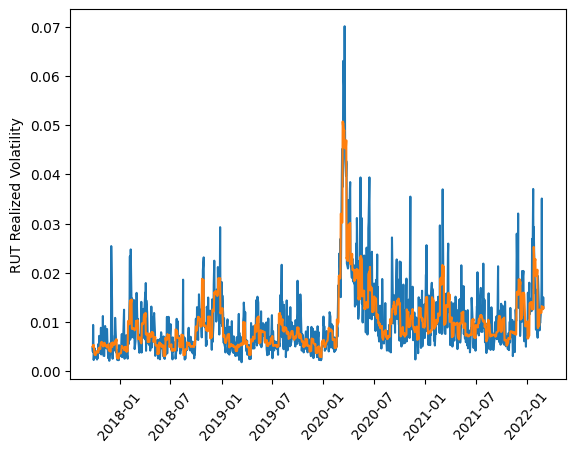

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("RUT Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [ ]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast with PH': Y_hat
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast with PH (NBEATSx).csv")